In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from stable_baselines3 import PPO
from PIDController import PIDController  # Custom PID controller class
from OT2Eenv import OT2Env as PIDEnv  # Environment for PID
from ot2_env_wrapper import OT2Env as RLEnv  # Environment for RL

# Function to generate random goals
def generate_random_goals(num_goals, bounds):
    """
    Generate random goals within the specified bounds.

    Args:
        num_goals (int): Number of goals to generate.
        bounds (list): List of [min_x, max_x, min_y, max_y, min_z, max_z].

    Returns:
        List of random goals [[x, y, z], ...].
    """
    return np.random.uniform(
        low=[bounds[0], bounds[2], bounds[4]],
        high=[bounds[1], bounds[3], bounds[5]],
        size=(num_goals, 3)
    ).tolist()

# Benchmarking function for PID controller
def benchmark_pid_controller(env, pid_controller, goals, controller_name="PID"):
    """
    Benchmark the PID controller with the given environment and goals.

    Args:
        env: The simulation environment.
        pid_controller: The PID controller instance.
        goals: List of goal positions [[x, y, z], ...].
        controller_name: Name of the controller (default="PID").

    Returns:
        List of results with time and accuracy for each goal.
    """
    results = []

    for idx, goal in enumerate(goals):
        print(f"Benchmarking {controller_name} for goal {idx + 1}")
        obs, _ = env.reset()
        env.goal_position = np.array(goal)  # Set the goal position in the environment
        pid_controller.prev_error = 0  # Reset the PID controller state
        pid_controller.integral = 0

        done = False
        start_time = time.time()

        try:
            while not done:
                # Compute errors for each axis
                current_position = obs[:3]  # Extract current position from observation
                error = env.goal_position - current_position

                # Compute PID control actions
                action = np.array([
                    pid_controller.compute(error[0]),
                    pid_controller.compute(error[1]),
                    pid_controller.compute(error[2])
                ])

                # Apply action in the environment
                obs, reward, done, truncated, _ = env.step(action)
                if truncated:
                    print(f"{controller_name} exceeded maximum steps for goal {idx + 1}")
                    break

            elapsed_time = time.time() - start_time
            final_error = np.linalg.norm(env.get_current_position() - env.goal_position)
            results.append({
                "Controller": controller_name,
                "Goal Index": idx + 1,
                "Time (s)": elapsed_time,
                "Final Error (mm)": final_error * 1000  # Convert to mm
            })
        except Exception as e:
            print(f"Error during {controller_name} execution for goal {idx + 1}: {e}")
            results.append({
                "Controller": controller_name,
                "Goal Index": idx + 1,
                "Time (s)": None,
                "Final Error (mm)": None
            })

    return results

# Benchmarking function for RL controller
def benchmark_rl_controller(env, rl_model, goals, controller_name="RL"):
    """
    Benchmark the RL controller with the given environment and goals.

    Args:
        env: The RL environment.
        rl_model: The trained RL model.
        goals: List of goal positions [[x, y, z], ...].
        controller_name: Name of the controller (default="RL").

    Returns:
        List of results with time and accuracy for each goal.
    """
    results = []

    for idx, goal in enumerate(goals):
        print(f"Benchmarking {controller_name} for goal {idx + 1}")
        obs, _ = env.reset()
        env.goal_position = np.array(goal)  # Set the goal position in the environment

        done = False
        start_time = time.time()

        try:
            while not done:
                action, _ = rl_model.predict(obs)
                obs, reward, done, truncated, _ = env.step(action)
                if truncated:
                    print(f"{controller_name} exceeded maximum steps for goal {idx + 1}")
                    break

            elapsed_time = time.time() - start_time
            final_error = np.linalg.norm(env.get_current_position() - env.goal_position)
            results.append({
                "Controller": controller_name,
                "Goal Index": idx + 1,
                "Time (s)": elapsed_time,
                "Final Error (mm)": final_error * 1000  # Convert to mm
            })
        except Exception as e:
            print(f"Error during {controller_name} execution for goal {idx + 1}: {e}")
            results.append({
                "Controller": controller_name,
                "Goal Index": idx + 1,
                "Time (s)": None,
                "Final Error (mm)": None
            })

    return results

# Visualization function for benchmarking results
def plot_benchmark_results(results_df):
    metrics = ["Time (s)", "Final Error (mm)"]
    controllers = results_df["Controller"].unique()
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for controller in controllers:
            controller_data = results_df[results_df["Controller"] == controller]
            plt.bar(
                controller_data["Goal Index"], 
                controller_data[metric], 
                label=controller, 
                alpha=0.7
            )
        plt.xlabel("Goal Index")
        plt.ylabel(metric)
        plt.title(f"Comparison of {metric} for PID and RL Controllers")
        plt.legend()
        plt.show()

# Main function
if __name__ == "__main__":
    # Initialize environments with max_steps=2000
    pid_env = PIDEnv(render=False, max_steps=2000)
    rl_env = RLEnv(render=False, max_steps=2000)

    # Initialize controllers
    pid_controller = PIDController(kp=10, ki=5, kd=0.1)
    rl_model = PPO.load(r"C:\Users\Edopi\Downloads\model (7).zip")

    # Define workspace bounds
    workspace_bounds = [-0.15, 0.15, -0.15, 0.15, 0.05, 0.2]

    # Generate random goals
    random_goals = generate_random_goals(10, workspace_bounds)

    # Benchmark PID and RL controllers
    pid_results = benchmark_pid_controller(pid_env, pid_controller, random_goals, "PID")
    rl_results = benchmark_rl_controller(rl_env, rl_model, random_goals, "RL")

    # Combine results into a DataFrame
    results_df = pd.DataFrame(pid_results + rl_results)
    results_df.to_csv("controller_benchmark_results.csv", index=False)

    # Visualize results
    plot_benchmark_results(results_df)


Benchmarking PID for goal 1
Reset: Pipette Position [0.073  0.0895 0.1195], Goal Position [ 0.21123283 -0.0322773   0.2805053 ]
Step 1 called.
Step 2 called.
Step 3 called.
Step 4 called.
Step 5 called.
Step 6 called.
Step 7 called.
Step 8 called.
Step 9 called.
Step 10 called.
Step 11 called.
Step 12 called.
Step 13 called.
Step 14 called.
Step 15 called.
Step 16 called.
Step 17 called.
Step 18 called.
Step 19 called.
Step 20 called.
Step 21 called.
Step 22 called.
Step 23 called.
Step 24 called.
Step 25 called.
Step 26 called.
Step 27 called.
Step 28 called.
Step 29 called.
Step 30 called.
Step 31 called.
Step 32 called.
Step 33 called.
Step 34 called.
Step 35 called.
Step 36 called.
Step 37 called.
Step 38 called.
Step 39 called.
Step 40 called.
Step 41 called.
Step 42 called.
Step 43 called.
Step 44 called.
Step 45 called.
Step 46 called.
Step 47 called.
Step 48 called.
Step 49 called.
Step 50 called.
Step 51 called.
Step 52 called.
Step 53 called.
Step 54 called.
Step 55 called.
S

KeyboardInterrupt: 

Generated single goal: [0.11262553620971852, 0.13084425189040214, 0.09044371446320942]
Benchmarking PID for goal: [0.11262553620971852, 0.13084425189040214, 0.09044371446320942]
Reset: Pipette Position [0.073  0.0895 0.1195], Goal Position [-0.1484416   0.00119141  0.22626053]
Step 1 called.
Step 2 called.
Step 3 called.
Step 4 called.
Step 5 called.
Step 6 called.
Step 7 called.
Step 8 called.
Step 9 called.
Step 10 called.
Step 11 called.
Step 12 called.
Step 13 called.
Step 14 called.
Step 15 called.
Step 16 called.
Step 17 called.
Step 18 called.
Step 19 called.
Step 20 called.
Step 21 called.
Step 22 called.
Step 23 called.
Step 24 called.
Step 25 called.
Step 26 called.
Step 27 called.
Step 28 called.
Step 29 called.
Step 30 called.
Step 31 called.
Step 32 called.
Step 33 called.
Step 34 called.
Step 35 called.
Step 36 called.
Step 37 called.
Step 38 called.
Step 39 called.
Step 40 called.
Step 41 called.
Step 42 called.
Step 43 called.
Step 44 called.
Step 45 called.
Step 46 cal

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

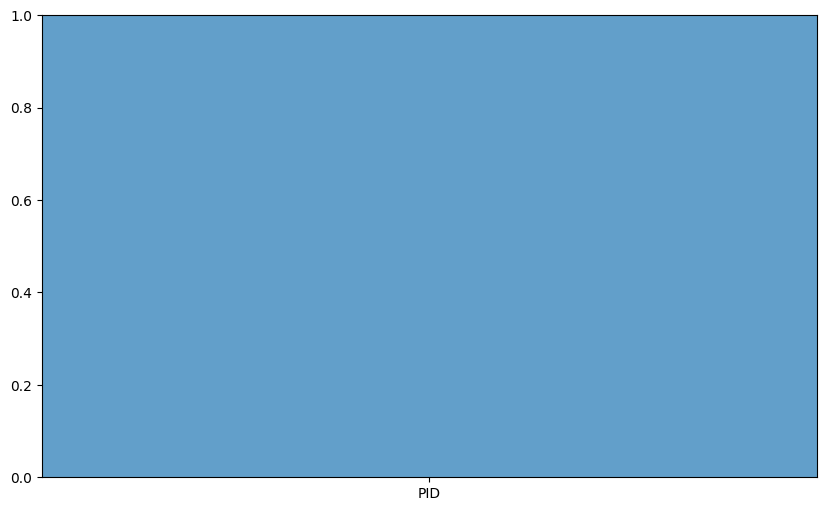

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from stable_baselines3 import PPO
from PIDController import PIDController  # Custom PID controller class
from OT2Eenv import OT2Env as PIDEnv  # Environment for PID
from ot2_env_wrapper import OT2Env as RLEnv  # Environment for RL

# Function to generate a single random goal
def generate_single_goal(bounds):
    """
    Generate a single random goal within the specified bounds.

    Args:
        bounds (list): List of [min_x, max_x, min_y, max_y, min_z, max_z].

    Returns:
        Single random goal [x, y, z].
    """
    return np.random.uniform(
        low=[bounds[0], bounds[2], bounds[4]],
        high=[bounds[1], bounds[3], bounds[5]],
        size=(3,)
    ).tolist()

# Benchmarking function for PID controller
def benchmark_pid_controller(goal, controller_name="PID"):
    """
    Benchmark the PID controller with the given goal.

    Args:
        goal: Single goal position [x, y, z].
        controller_name: Name of the controller (default="PID").

    Returns:
        Dictionary of results with time and accuracy.
    """
    print(f"Benchmarking {controller_name} for goal: {goal}")
    pid_env = PIDEnv(render=False, max_steps=2000)  # Create a new PID environment instance
    pid_controller = PIDController(kp=10, ki=5, kd=0.1)  # Initialize the PID controller

    obs, _ = pid_env.reset()
    pid_env.goal_position = np.array(goal)  # Set the goal position in the environment
    pid_controller.prev_error = 0  # Reset the PID controller state
    pid_controller.integral = 0

    done = False
    start_time = time.time()

    try:
        while not done:
            # Compute errors for each axis
            current_position = obs[:3]  # Extract current position from observation
            error = pid_env.goal_position - current_position

            # Compute PID control actions
            action = np.array([
                pid_controller.compute(error[0]),
                pid_controller.compute(error[1]),
                pid_controller.compute(error[2])
            ])

            # Apply action in the environment
            obs, reward, done, truncated, _ = pid_env.step(action)
            if truncated:
                print(f"{controller_name} exceeded maximum steps.")
                break

        elapsed_time = time.time() - start_time
        final_error = np.linalg.norm(pid_env.get_current_position() - pid_env.goal_position)
        return {
            "Controller": controller_name,
            "Time (s)": elapsed_time,
            "Final Error (mm)": final_error * 1000  # Convert to mm
        }
    except Exception as e:
        print(f"Error during {controller_name} execution: {e}")
        return {
            "Controller": controller_name,
            "Time (s)": None,
            "Final Error (mm)": None
        }
    finally:
        pid_env.close()  # Ensure the environment is closed properly

# Benchmarking function for RL controller
def benchmark_rl_controller(goal, controller_name="RL"):
    """
    Benchmark the RL controller with the given goal.

    Args:
        goal: Single goal position [x, y, z].
        controller_name: Name of the controller (default="RL").

    Returns:
        Dictionary of results with time and accuracy.
    """
    print(f"Benchmarking {controller_name} for goal: {goal}")
    rl_env = RLEnv(render=False, max_steps=2000)  # Create a new RL environment instance
    rl_model = PPO.load(r"C:\Users\Edopi\Downloads\model (7).zip")  # Load RL model

    obs, _ = rl_env.reset()
    rl_env.goal_position = np.array(goal)  # Set the goal position in the environment

    done = False
    start_time = time.time()

    try:
        while not done:
            action, _ = rl_model.predict(obs)
            obs, reward, done, truncated, _ = rl_env.step(action)
            if truncated:
                print(f"{controller_name} exceeded maximum steps.")
                break

        elapsed_time = time.time() - start_time
        final_error = np.linalg.norm(rl_env.get_current_position() - rl_env.goal_position)
        return {
            "Controller": controller_name,
            "Time (s)": elapsed_time,
            "Final Error (mm)": final_error * 1000  # Convert to mm
        }
    except Exception as e:
        print(f"Error during {controller_name} execution: {e}")
        return {
            "Controller": controller_name,
            "Time (s)": None,
            "Final Error (mm)": None
        }
    finally:
        rl_env.close()  # Ensure the environment is closed properly

# Visualization function for benchmarking results
def plot_benchmark_results(results):
    metrics = ["Time (s)", "Final Error (mm)"]
    controllers = [result["Controller"] for result in results]
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        values = [result[metric] for result in results]
        plt.bar(controllers, values, alpha=0.7)
        plt.xlabel("Controller")
        plt.ylabel(metric)
        plt.title(f"Comparison of {metric} for PID and RL Controllers")
        plt.show()

# Main function
if __name__ == "__main__":
    # Define workspace bounds
    workspace_bounds = [-0.15, 0.15, -0.15, 0.15, 0.05, 0.2]

    # Generate a single goal
    single_goal = generate_single_goal(workspace_bounds)
    print(f"Generated single goal: {single_goal}")

    # Benchmark PID and RL controllers
    pid_result = benchmark_pid_controller(single_goal, "PID")
    rl_result = benchmark_rl_controller(single_goal, "RL")

    # Combine results
    results = [pid_result, rl_result]

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("controller_benchmark_results_single_goal.csv", index=False)

    # Visualize results
    plot_benchmark_results(results)
